This is a Markdown cell

In [2]:
%matplotlib inline
import numpy as np
import pyshtools
import shtaper
import copy
import cartopy.crs as ccrs

In [3]:
# to do

In [71]:
grid_step = 0.25
SH_lmax_grid = int(90/grid_step - 1)  # max degree to get a grid_step spaced grid
new_ref_r0 = pyshtools.constant.a_wgs84.value + 8e3 # outside of body (upward continuation)
obs_height = 20e3  # m
obs_a = pyshtools.constant.a_wgs84.value + obs_height

In [12]:
GGM_cilm, GGM_gm, GGM_r0 = \
    pyshtools.shio.read_icgem_gfc('XGM2019.gfc', lmax=SH_lmax_grid)
GTM_cilm, GTM_gm, GTM_r0 = \
    pyshtools.shio.read_icgem_gfc('dV_ELL_Earth2014.gfc', lmax=SH_lmax_grid)

In [13]:
GGM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GGM_cilm, GGM_gm, GGM_r0,
    omega=pyshtools.constant.omega_wgs84.value,
    lmax=SH_lmax_grid)
GTM_coeffs = pyshtools.SHGravCoeffs.from_array(
    GTM_cilm, GTM_gm, GTM_r0,
    omega=0,
    lmax=SH_lmax_grid)

In [14]:
GGM_coeffs = GGM_coeffs.change_ref(gm=GGM_gm, r0=new_ref_r0)
GTM_coeffs = GTM_coeffs.change_ref(gm=GGM_gm, r0=new_ref_r0)

In [15]:
LP_weights = \
    shtaper.taper_weights(l_start=300, l_stop=SH_lmax_grid, taper="gentle")

GGM_coeffs_LP = copy.deepcopy(GGM_coeffs)
GGM_coeffs_LP.coeffs = np.multiply(GGM_coeffs_LP.coeffs, LP_weights)

GTM_coeffs_LP = copy.deepcopy(GTM_coeffs)
GTM_coeffs_LP.coeffs = np.multiply(GTM_coeffs_LP.coeffs, LP_weights)

In [47]:
GGM_grid = pyshtools.SHGravCoeffs.expand(
    GGM_coeffs_LP,
    a=obs_a, f=pyshtools.constant.f_wgs84.value,
    extend=False, lmax=SH_lmax_grid, normal_gravity=True)
GGM_grid_gd = pyshtools.SHGrid.from_array(GGM_grid.total.data*1e5)  # to mGal
GTM_grid = pyshtools.SHGravCoeffs.expand(
    GTM_coeffs_LP,
    a=obs_a, f=pyshtools.constant.f_wgs84.value,
    extend=False, lmax=SH_lmax_grid, normal_gravity=False)
GTM_grid_rad = pyshtools.SHGrid.from_array(GTM_grid.rad.data * -1e5)  # to mGal and positive downwards

## Apply the terrain correction

The 'proper way' described above is implemented by
1. synthesizing the SH coefficients of the gravity model and the terrain effect model on a grid each, without providing *GM*
2. performing the difference between these two *"adimensional fields"*, subtracting the terrain effect grid from the gravity model field grid
3. expanding the terrain-corrected field to SH coefficients, in `pyshtools.SHGravCoeffs` class, providing *GM*, *r0*, *omega*
4. computing the terrain-refined gravity grids (`pyshtools.SHGravGrid` class). Now, and now only, we remove the normal gravity.

`Vbg_GravGrid_total` is a grid (`pyshtools.SHGrid` class) of the synthesized terrain-refined gravity disturbance, which is then used for map plotting. This is indeed redundant respect to `Vbg_GravGrid`.

In [48]:
# apply terrain correction
# perform difference of potential (adimensional) grid, then expand to SH coefficients, then to gravity grids
# normal gravity is removed after applying the reduction
# (potential issue: what if gm and r0 are different between GGM and terrain effect model?)

GGM_PotGrid_adim = (pyshtools.SHCoeffs.from_array(GGM_cilm)).expand()
GTM_PotGrid_adim_low = (pyshtools.SHCoeffs.from_array(GTM_cilm)).expand()
Vbg_Coeffs = (
    pyshtools.SHGrid.from_array(
        GGM_PotGrid_adim.data - GTM_PotGrid_adim_low.data
    )).expand()
Vbg_GravCoeffs = pyshtools.SHGravCoeffs.from_array(Vbg_Coeffs.coeffs,
                                                   gm=GGM_gm, r0=GGM_r0,
                                                   omega=pyshtools.constant.omega_wgs84.value)
Vbg_GravGrid = Vbg_GravCoeffs.expand(normal_gravity=True,
                                     a=obs_a, f=pyshtools.constant.f_wgs84.value)
Vbg_GravGrid_total = pyshtools.SHGrid.from_array(Vbg_GravGrid.total.data * 1e5)

In [72]:
fig_dpi = 100
fig_projection = ccrs.Robinson()

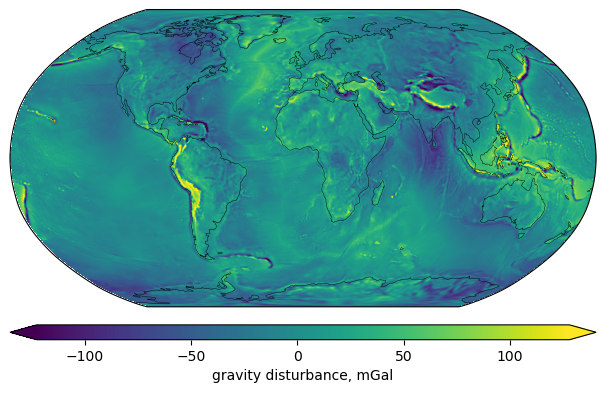

In [73]:
GGM_gd_fig, GGM_gd_ax = GGM_grid_gd.plot(projection=fig_projection,
                                         colorbar="bottom", cmap='viridis',
                                         cmap_limits=[
                                             np.quantile(GGM_grid_gd.data,0.001),
                                             np.quantile(GGM_grid_gd.data,0.999)
                                         ], cb_triangles="both",
                                         cb_label = 'gravity disturbance, mGal',
                                         show=False)
GGM_gd_ax.coastlines(resolution='110m', color='black', linewidth=0.3)
GGM_gd_fig.set_dpi(fig_dpi)
GGM_gd_fig.show()

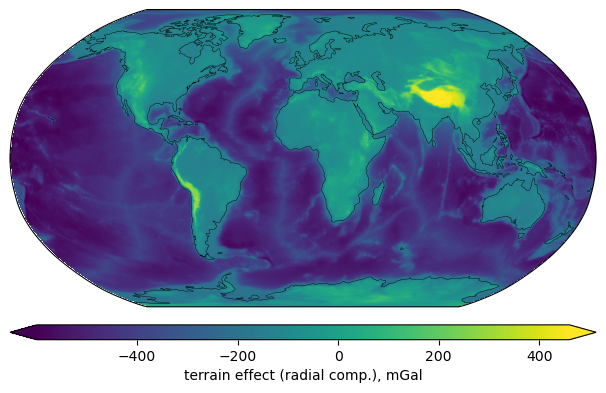

In [74]:
GTM_rad_fig, GTM_rad_ax = GTM_grid_rad.plot(projection=fig_projection,
                                            colorbar="bottom", cmap='viridis',
                                            cmap_limits=[
                                                np.quantile(GTM_grid_rad.data,0.001),
                                                np.quantile(GTM_grid_rad.data,0.999)
                                            ], cb_triangles="both",
                                            cb_label = 'terrain effect (radial comp.), mGal',
                                            show=False)
GTM_rad_ax.coastlines(resolution='110m', color='black', linewidth=0.3)
GTM_rad_fig.set_dpi(fig_dpi)
GTM_rad_fig.show()

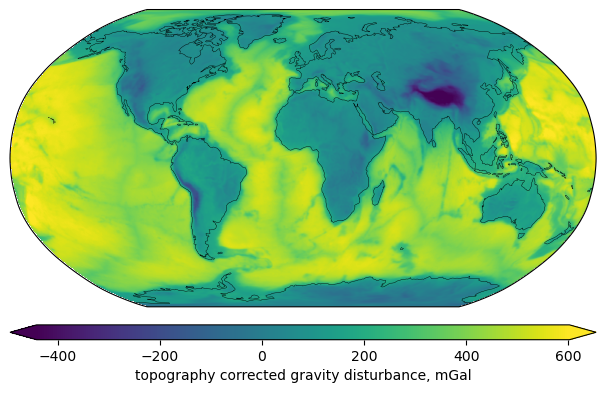

In [75]:
BG_fig, BG_ax = Vbg_GravGrid_total.plot(projection=fig_projection,
                                        colorbar="bottom", cmap='viridis',
                                        cmap_limits=[
                                            np.quantile(Vbg_GravGrid_total.data,0.001),
                                            np.quantile(Vbg_GravGrid_total.data,0.999)
                                        ], cb_triangles="both",
                                        cb_label = 'topography corrected gravity disturbance, mGal',
                                        show=False)
BG_ax.coastlines(resolution='110m', color='black', linewidth=0.3)
BG_fig.set_dpi(fig_dpi)
BG_fig.show()